In [33]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/mat/Documents/iot/hand-gesture-recognition-mediapipe/.env/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


# 各パス指定

In [34]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [35]:
NUM_CLASSES = 4

# 入力長

In [36]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [37]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [38]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [40]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.LSTM(16, time_major=False, return_sequences=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 2)             0         
                                                                 
 dropout (Dropout)           (None, 16, 2)             0         
                                                                 
 lstm (LSTM)                 (None, 16, 16)            1216      
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
 dense_1 (Dense)             (None, 4)                 4

In [41]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [42]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [43]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
30/32 [===========================>..] - ETA: 0s - loss: 1.3800 - accuracy: 0.4471
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 2s 21ms/step - loss: 1.3799 - accuracy: 0.4466 - val_loss: 1.3734 - val_accuracy: 0.5038
Epoch 2/1000
29/32 [==========================>...] - ETA: 0s - loss: 1.3640 - accuracy: 0.4970
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 14ms/step - loss: 1.3630 - accuracy: 0.4960 - val_loss: 1.3492 - val_accuracy: 0.5174
Epoch 3/1000
31/32 [============================>.] - ETA: 0s - loss: 1.3233 - accuracy: 0.5141
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 1s 16ms/step - loss: 1.3233 - accuracy: 0.5141 - val_loss: 1.2959 - val_accuracy: 0.5053
Epoch 4/1000
30/32 [===========================>..] - ETA: 0s - 

In [44]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [45]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 236ms/step
[9.6649086e-01 1.6121580e-03 7.5118884e-04 3.1145761e-02]
0


# 混同行列

## 1. 非LSTM

42/42 [==============================] - 0s 2ms/step


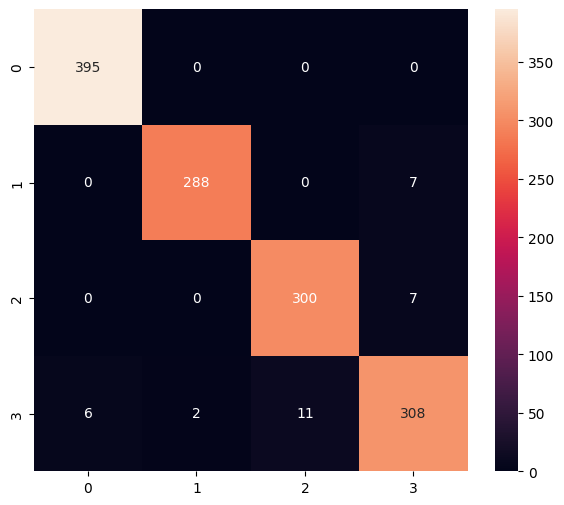

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.99      0.98      0.98       295
           2       0.96      0.98      0.97       307
           3       0.96      0.94      0.95       327

    accuracy                           0.98      1324
   macro avg       0.97      0.97      0.97      1324
weighted avg       0.98      0.98      0.98      1324



In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## 2. LSTM

42/42 [==============================] - 0s 3ms/step


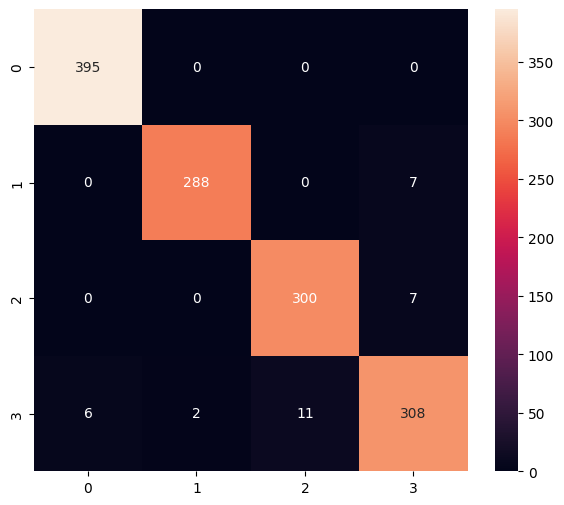

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.99      0.98      0.98       295
           2       0.96      0.98      0.97       307
           3       0.96      0.94      0.95       327

    accuracy                           0.98      1324
   macro avg       0.97      0.97      0.97      1324
weighted avg       0.98      0.98      0.98      1324



In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [48]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [ ]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'
saved_model_path = 'saved_model'

In [50]:
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [51]:
# モデルを変換
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2025-12-26 12:20:50.136795: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-12-26 12:20:50.136828: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-12-26 12:20:50.136963: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: saved_model
2025-12-26 12:20:50.144549: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-12-26 12:20:50.144610: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: saved_model
2025-12-26 12:20:50.173791: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2025-12-26 12:20:50.225091: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: saved_model
2025-12-26 12:20:50.263513: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 126552 microseconds.
2

15104

# ONNXへの変換

In [ ]:
!python -m tf2onnx.convert --opset 11 --saved-model saved_model --output point_history_classifier.onnx

2025-12-26 12:22:31.764574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-26 12:22:31.837266: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-26 12:22:31.840474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-12-26 12:22:31.840486: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [ ]:
!onnxsim point_history_classifier.onnx point_history_classifier.onnx
!onnxsim point_history_classifier.onnx point_history_classifier.onnx
!onnxsim point_history_classifier.onnx point_history_classifier.onnx

# 推論テスト

In [28]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 17 nodes with 2 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [29]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [30]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [31]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 1.15 ms


In [32]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.7926694e-01 1.3084083e-03 1.1282025e-04 1.9311896e-02]
0
